In [1]:
!pip install torchdyn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82

In [2]:
!pip install torchcfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 15.6 MB/s eta 0:00:00


In [1]:
import os
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from tqdm import trange
import wandb

from torchdyn.core import NeuralODE
from torchcfm.models.unet.unet import UNetModelWrapper

In [2]:
def warmup_lr(step, WARMUP=5000):
    """Simple warmup schedule from 0 to initial LR over first WARMUP steps."""
    return min(step, WARMUP) / WARMUP

def infiniteloop(dataloader):
    """Creates an infinite iterator over a given dataloader."""
    while True:
        for x, _ in dataloader:
            yield x

@torch.no_grad()
def generate_samples(model,
                     savedir="./results_mnist/",
                     step_=0,
                     total_steps=100,
                     net_="normal",
                     samples= 32,
                     plot=False):
    """
    Generate and save 32 unconditional MNIST samples at 28×28 resolution.
    """
    model.eval()
    model_ = copy.deepcopy(model)

    node_ = NeuralODE(model_, solver="euler", sensitivity="adjoint").to(device)

    # Generate random noise in shape (32, 1, 28, 28)
    z = torch.randn(samples, 1, 28, 28, device=device)

    # Integrate from t=0 to t=1
    t_span = torch.linspace(0, 1, total_steps, device=device)
    traj = node_.trajectory(z, t_span)  # shape: [total_steps, 32, 1, 28, 28]

    # Final state
    x_gen = traj[-1].clamp(-1, 1)
    x_gen = x_gen / 2 + 0.5  # move from [-1,1] to [0,1]

    os.makedirs(savedir, exist_ok=True)
    img_path = f"{savedir}/{net_}_generated_FM_step_{step_}_total_{total_steps}.png"
    save_image(x_gen, img_path, nrow=8)

    if plot:
        import matplotlib.pyplot as plt
        grid = make_grid(x_gen, nrow=8)
        plt.figure(figsize=(8, 8))
        # For grayscale, we can do cmap="gray"
        plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap="gray")
        plt.title(f"MNIST Gen: {net_} | total_steps={total_steps-1}")
        plt.axis("off")
        plt.show()

    model.train()

def ema(source, target, decay=0.9999):
    """EMA update of target's params from source."""
    source_dict = source.state_dict()
    target_dict = target.state_dict()
    for k in source_dict.keys():
        target_dict[k].data.copy_(
            target_dict[k].data * decay + source_dict[k].data * (1 - decay)
        )


In [3]:
############################
# 2) MNIST Data Loader
############################
def get_mnist_dataloader(batch_size=64):
    transform = transforms.Compose([
        # NO RESIZE -> keep 28×28
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Single-channel normalization
    ])

    mnist_train = datasets.MNIST(
        root="./data_mnist",
        train=True,
        transform=transform,
        download=True
    )
    loader = DataLoader(
        mnist_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        drop_last=True,
        pin_memory=True
    )
    return loader

In [4]:
###########################
# 3) Define U-Net for 1×28×28
############################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


net_model = UNetModelWrapper(
    dim=(1, 28, 28),      # 1 channel, 28×28
    num_res_blocks=2,
    num_channels=64,      # smaller base than 128, since MNIST is easier
    channel_mult=[1, 2],  # just one downsampling: 28->14
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="14",
    dropout=0.05,
).to(device)

ema_model = copy.deepcopy(net_model)

# Print model size
model_size = sum(p.numel() for p in net_model.parameters())
print("Model params: %.2f M" % (model_size / 1024 / 1024))


Model params: 3.81 M


In [5]:
############################
# 4) Flow Matching Trainer
############################
import torch.nn as nn

def train_flowmatching_mnist(
    TOTAL_STEPS=50000,
    BATCH_SIZE=64,
    LR=2e-4,
    GRAD_CLIP=1.0,
    SAVE_STEP=1000,
    WARMUP=5000
):
    mnist_loader = get_mnist_dataloader(batch_size=BATCH_SIZE)
    data_loop = infiniteloop(mnist_loader)

    optimizer = torch.optim.Adam(net_model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, lr_lambda=lambda s: warmup_lr(s, WARMUP=WARMUP)
    )

    loss_fn = nn.MSELoss()

    # Close previous W&B run if present
    if wandb.run is not None:
        wandb.finish()
    wandb.init(project="MNIST-FM-28x28")

    pbar = trange(TOTAL_STEPS, desc="FlowMatching", dynamic_ncols=True)
    for step in pbar:
        optimizer.zero_grad()

        x_1 = next(data_loop).to(device)   # shape: (B, 1, 28, 28)
        x_0 = torch.randn_like(x_1)        # shape: (B, 1, 28, 28)

        B = x_1.size(0)
        t = torch.rand((B, 1), device=device).view(B, 1, 1, 1)
        x_t = t * x_1 + (1 - t) * x_0
        v_target = x_1 - x_0

        # Forward
        t_flat = t.squeeze()
        v_predict = net_model(t_flat, x_t)
        loss = loss_fn(v_predict, v_target)

        # Backward + clip
        loss.backward()
        nn.utils.clip_grad_norm_(net_model.parameters(), GRAD_CLIP)
        optimizer.step()
        scheduler.step()

        # EMA update
        ema(net_model, ema_model)

        # Logging
        wandb.log({"train_loss": loss.item(), "step": step})
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        # Save periodically
        if SAVE_STEP > 0 and step > 0 and (step % SAVE_STEP == 0):
            os.makedirs("./checkpoints_mnist/", exist_ok=True)

            generate_samples(
                net_model,
                step_=step,
                savedir="./checkpoints_mnist/img/normal/",
                total_steps=100,
                net_="normal"
            )
            generate_samples(
                ema_model,
                step_=step,
                savedir="./checkpoints_mnist/img/ema/",
                total_steps=100,
                net_="ema"
            )

            ckpt_path = f"./checkpoints_mnist/fm_mnist_step_{step}.pth"
            torch.save({
                "net_model": net_model.state_dict(),
                "ema_model": ema_model.state_dict(),
                "sched": scheduler.state_dict(),
                "optim": optimizer.state_dict(),
                "step": step,
            }, ckpt_path)
            wandb.save(ckpt_path)

    print("Training completed!")
    wandb.finish()


In [ ]:
############################
# 5) Run Training
############################
if __name__ == "__main__":
    train_flowmatching_mnist(
        TOTAL_STEPS=60001,
        BATCH_SIZE=64,
        LR=2e-4,
        GRAD_CLIP=1.0,
        SAVE_STEP=1000,
        WARMUP=3000
    )

step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_loss,▄▄▆▄▃▅▅▅▁▆▇▄▃▃▇▄▆▆▄▅▅▅▅▅█▄▅▆▇▅▇▅▄▄▅▅▅▆▅▄
step,12941
train_loss,0.15024


FlowMatching: 100%|██████████| 60001/60001 [1:11:45<00:00, 13.94it/s, loss=0.1465]

Training completed!


step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
train_loss,██▇▇█▇▇▆▅▄▆▅▅▅█▇▅▃▄▄▄▁▆▇▄▃▄▃▄▃▃▄▃▂▄▃▃▄▄▅
step,60000
train_loss,0.1465


In [7]:
# Load a checkpoint you trained on MNIST

import os

ckpt_path = "fm_mnist_step_60000 (2).pth"
print(os.path.exists(ckpt_path), os.path.getsize(ckpt_path))

checkpoint = torch.load(ckpt_path, map_location=device)

state_dict_ema    = checkpoint["ema_model"]

ema_model.load_state_dict(state_dict_ema)

ema_model.eval()

True 64149842


UNetModelWrapper(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.05, inplace=False)
          (3): Conv2d(64, 64, kernel_size=(3, 3),

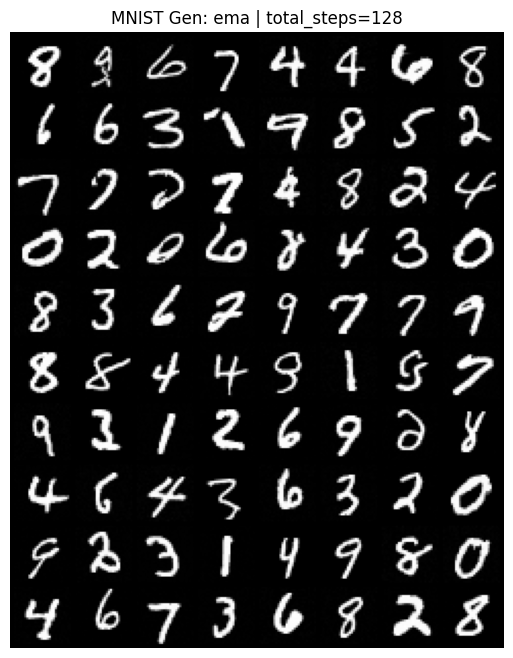

In [15]:
generate_samples(ema_model, total_steps=129, samples=80, net_="ema", plot=True)